## Loading

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import helper 
import warnings
current_path = os.getcwd()


In [3]:
# Define a context manager to temporarily suppress FutureWarnings
class SuppressFutureWarnings:
    def __enter__(self):
        warnings.filterwarnings('ignore', category=FutureWarning)
    
    def __exit__(self, exc_type, exc_value, traceback):
        warnings.filterwarnings('default')

In [4]:
TECH_GIANTS = ["TSLA", "AAPL", 'QQQ', "SPY", "MSFT", "AMZN", "GOOG"]
start_date = "2010-01-01"
end_date = "2023-01-01"
stock_data = {}

for stock in TECH_GIANTS: 
    try:
        data_path = current_path + "\data" f"\{stock}_{start_date}_{end_date}.csv"
        data = pd.read_csv(data_path)
        data['Date'] = pd.to_datetime(data['Date'])
        data = helper.compute_rsi_class(data)  # Assuming you have this function in helper
        data = helper.compute_volume_class(data)  # Add volume analysis
        stock_data[stock] = data
        print(f"Data fetched for {stock}")
    except Exception as e:
        print(f"Error fetching data for {stock}: {str(e)}")

Data fetched for TSLA
Data fetched for AAPL
Data fetched for QQQ
Data fetched for SPY
Data fetched for MSFT
Data fetched for AMZN
Data fetched for GOOG


## Analysis

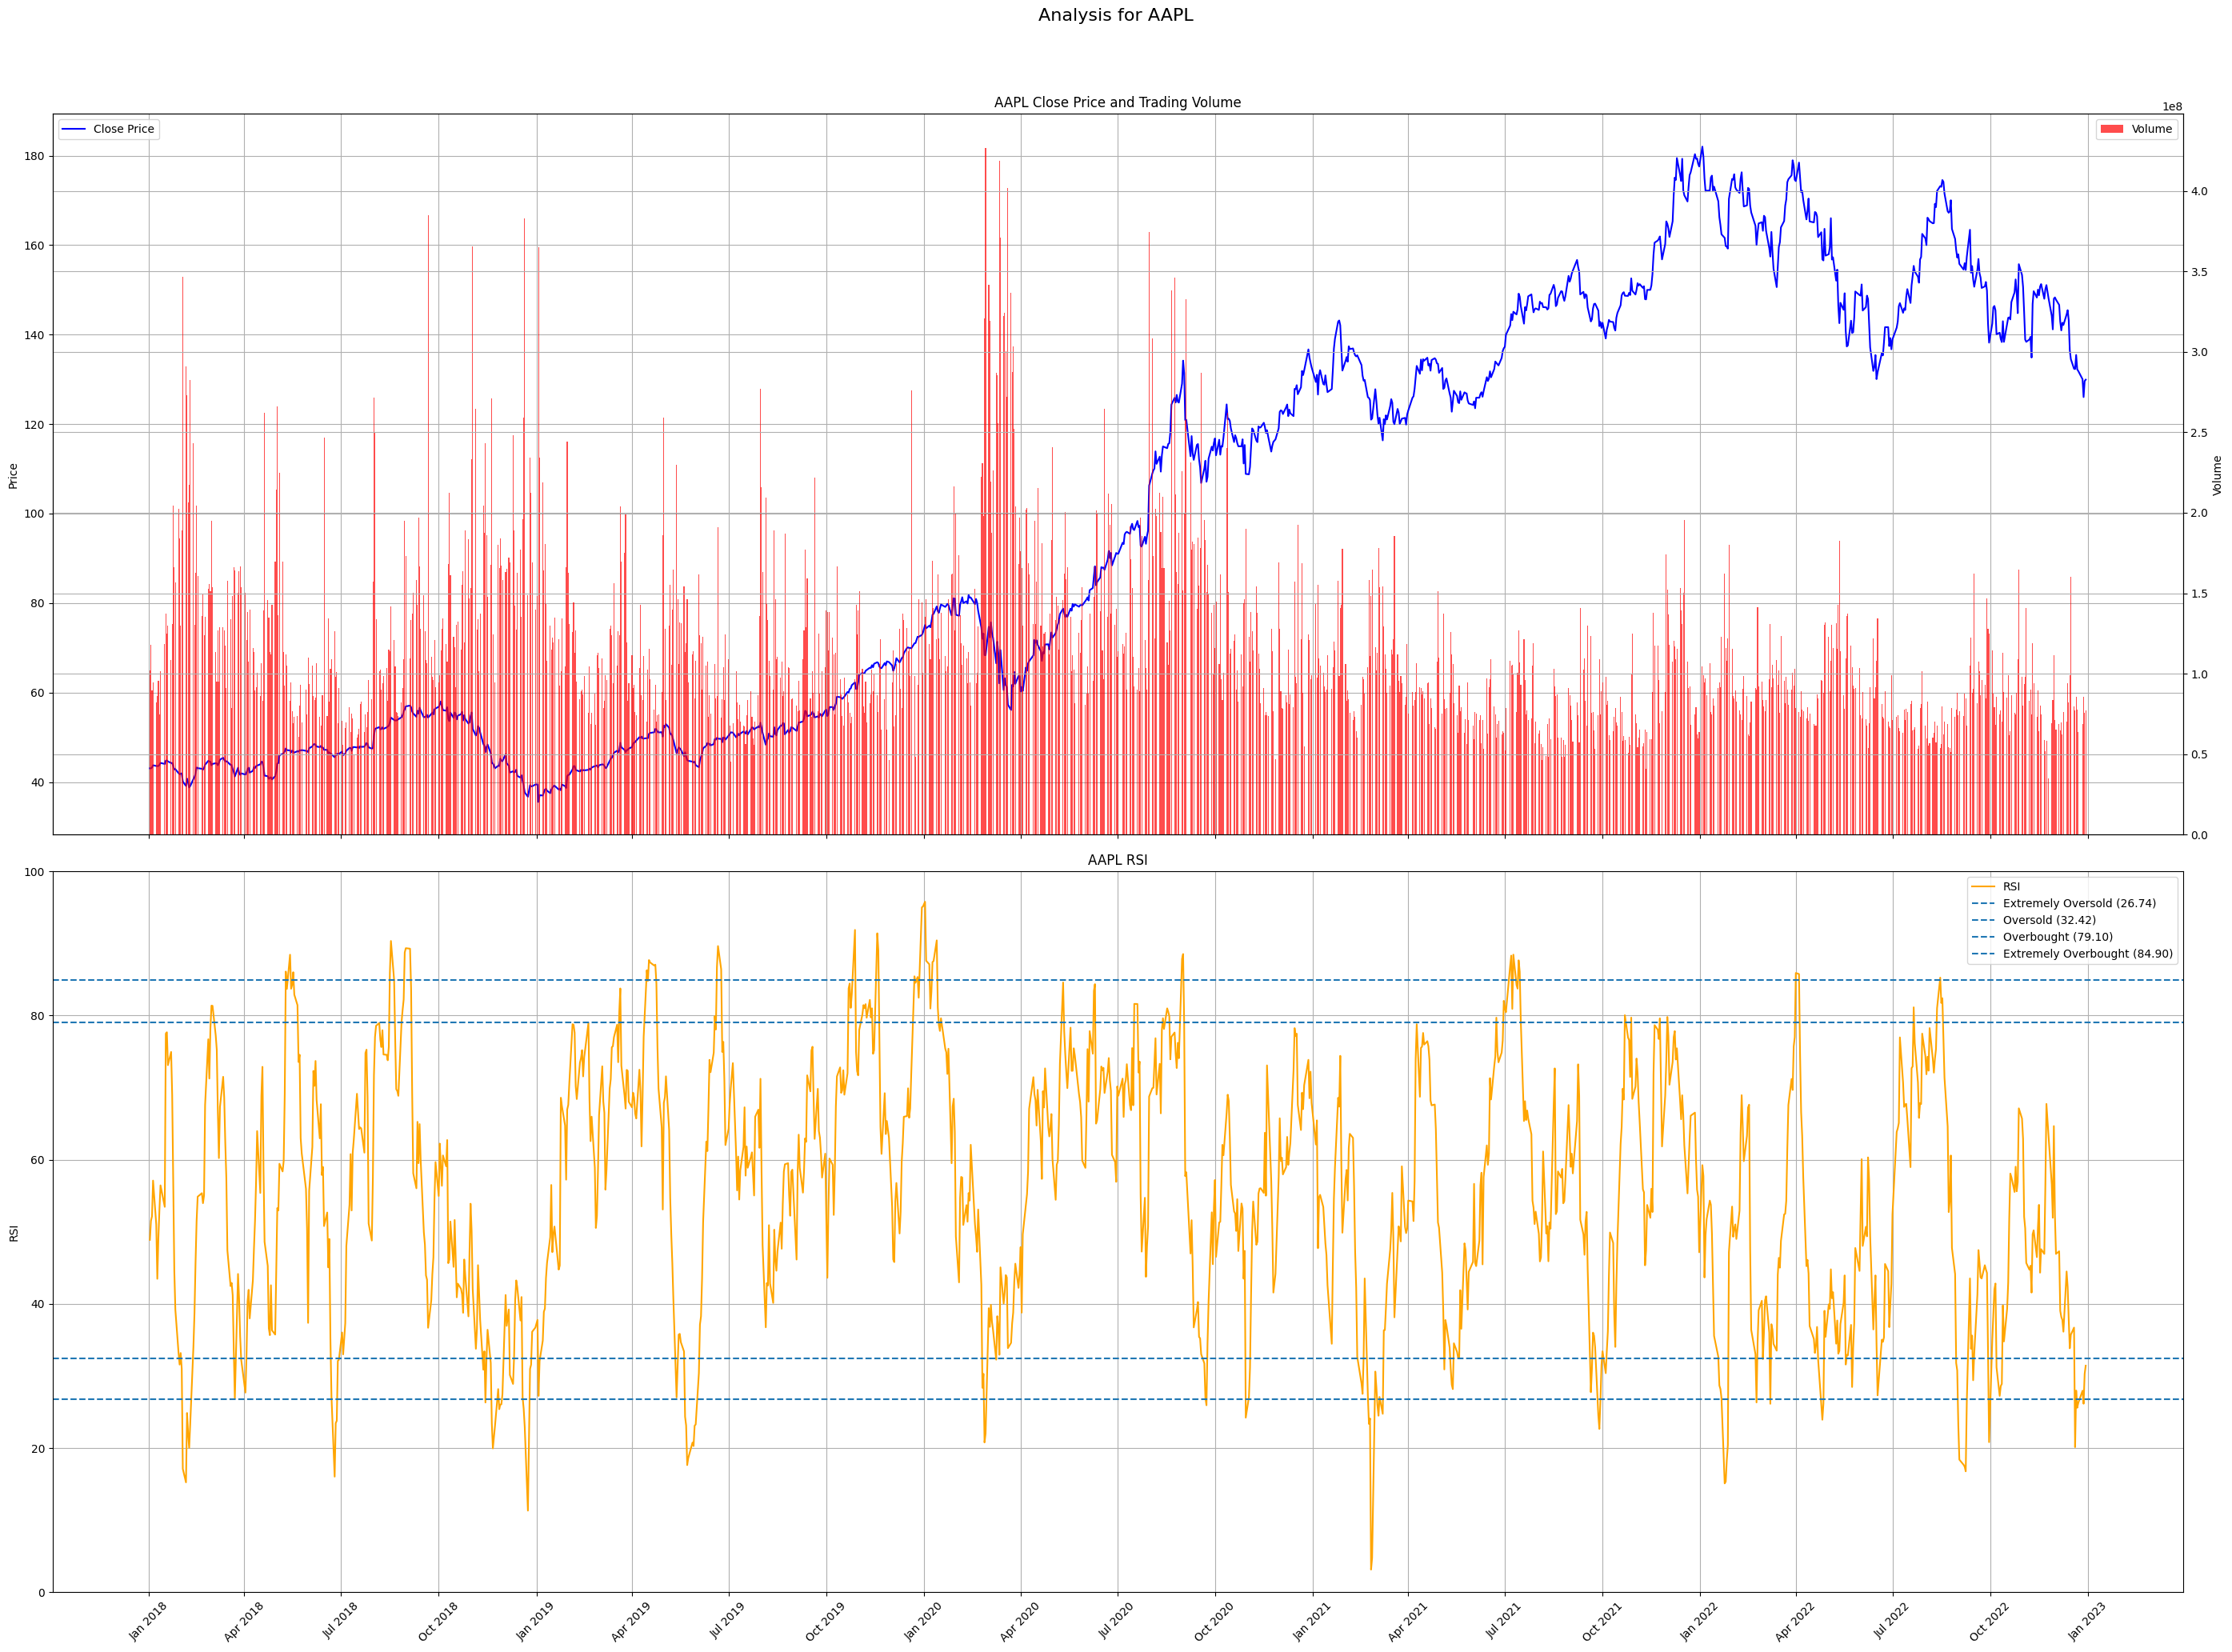

In [5]:
for stock, data in stock_data.items():
    if stock == "AAPL":
        data = data[data['Date'] >= "2018-01-01"]
        helper.plot_stock_data(stock, data)
        break

In [6]:
correlations = {}
price = 'Adj Close'
AAPL_close = stock_data["AAPL"][price]

for stock, data in stock_data.items():
    if stock != 'AAPL':  # We don't want to compare AAPL with itself
        other_close = data[price]
        
        combined_data = pd.concat([AAPL_close, other_close], axis=1, join='inner')
        combined_data.columns = ['AAPL', stock]
        
        combined_data.dropna(inplace=True)
        
        correlation = np.corrcoef(combined_data['AAPL'], combined_data[stock])[0, 1]
        correlations[stock] = correlation

print(correlations)


{'TSLA': 0.9328597403066972, 'QQQ': 0.9710468578221616, 'SPY': 0.9517774093470768, 'MSFT': 0.9853626754063121, 'AMZN': 0.9204029863785401, 'GOOG': 0.9663440649777281}


### Volume

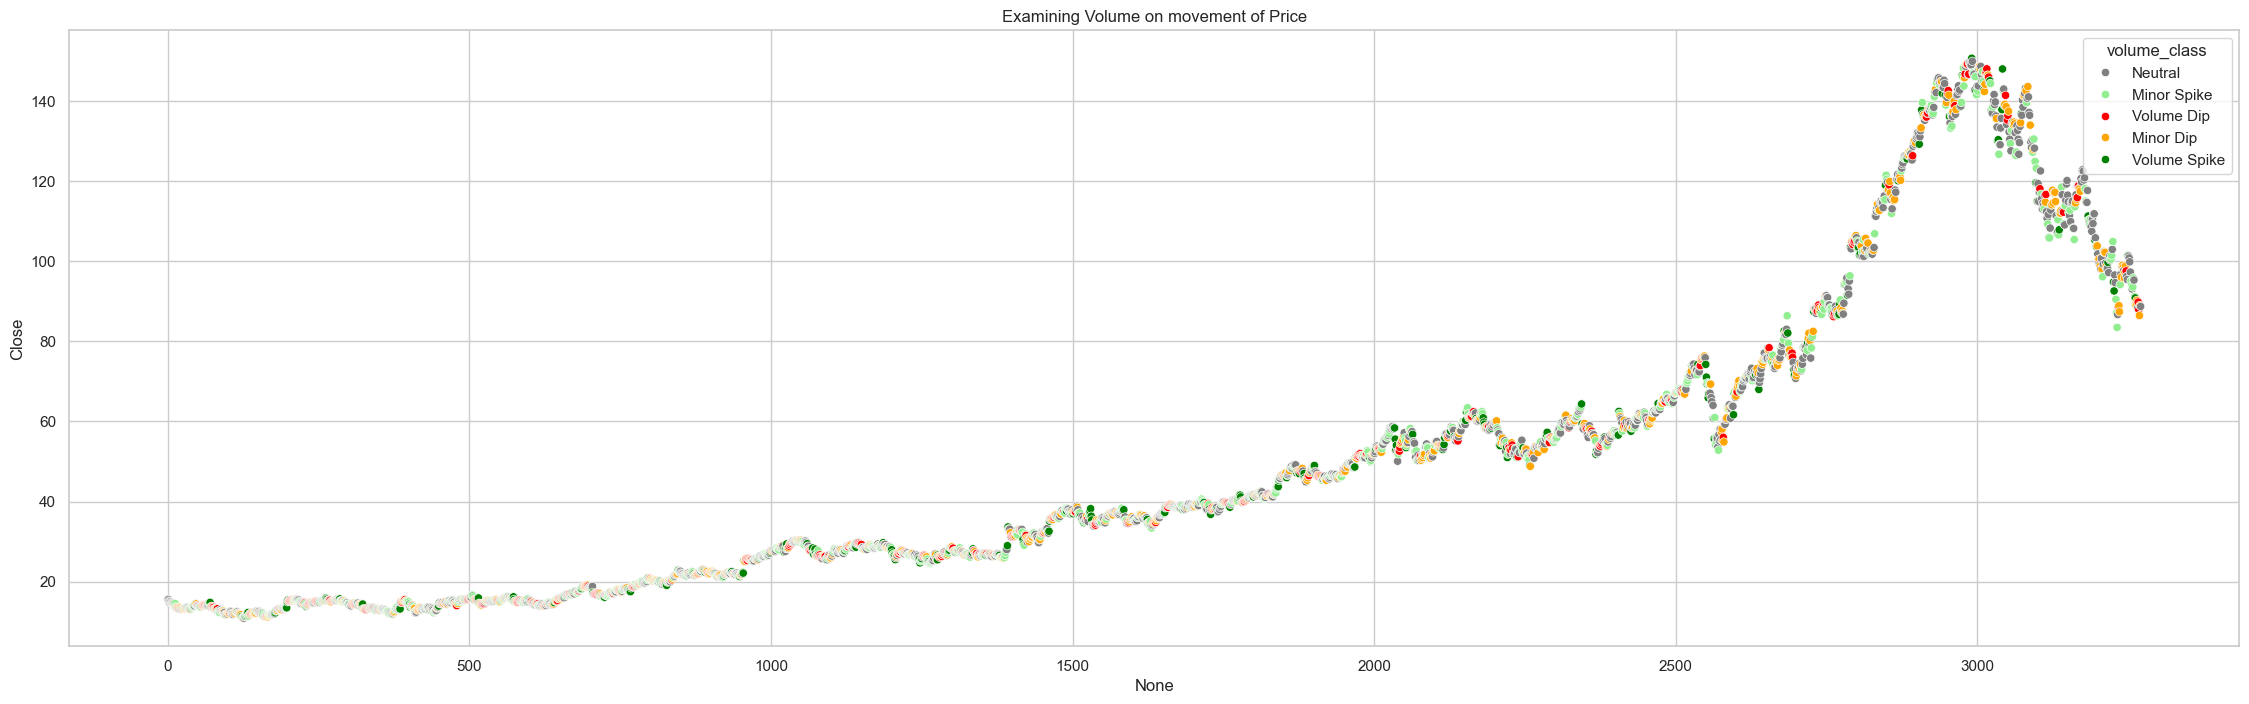

In [7]:
helper.plot_volume_category(data)

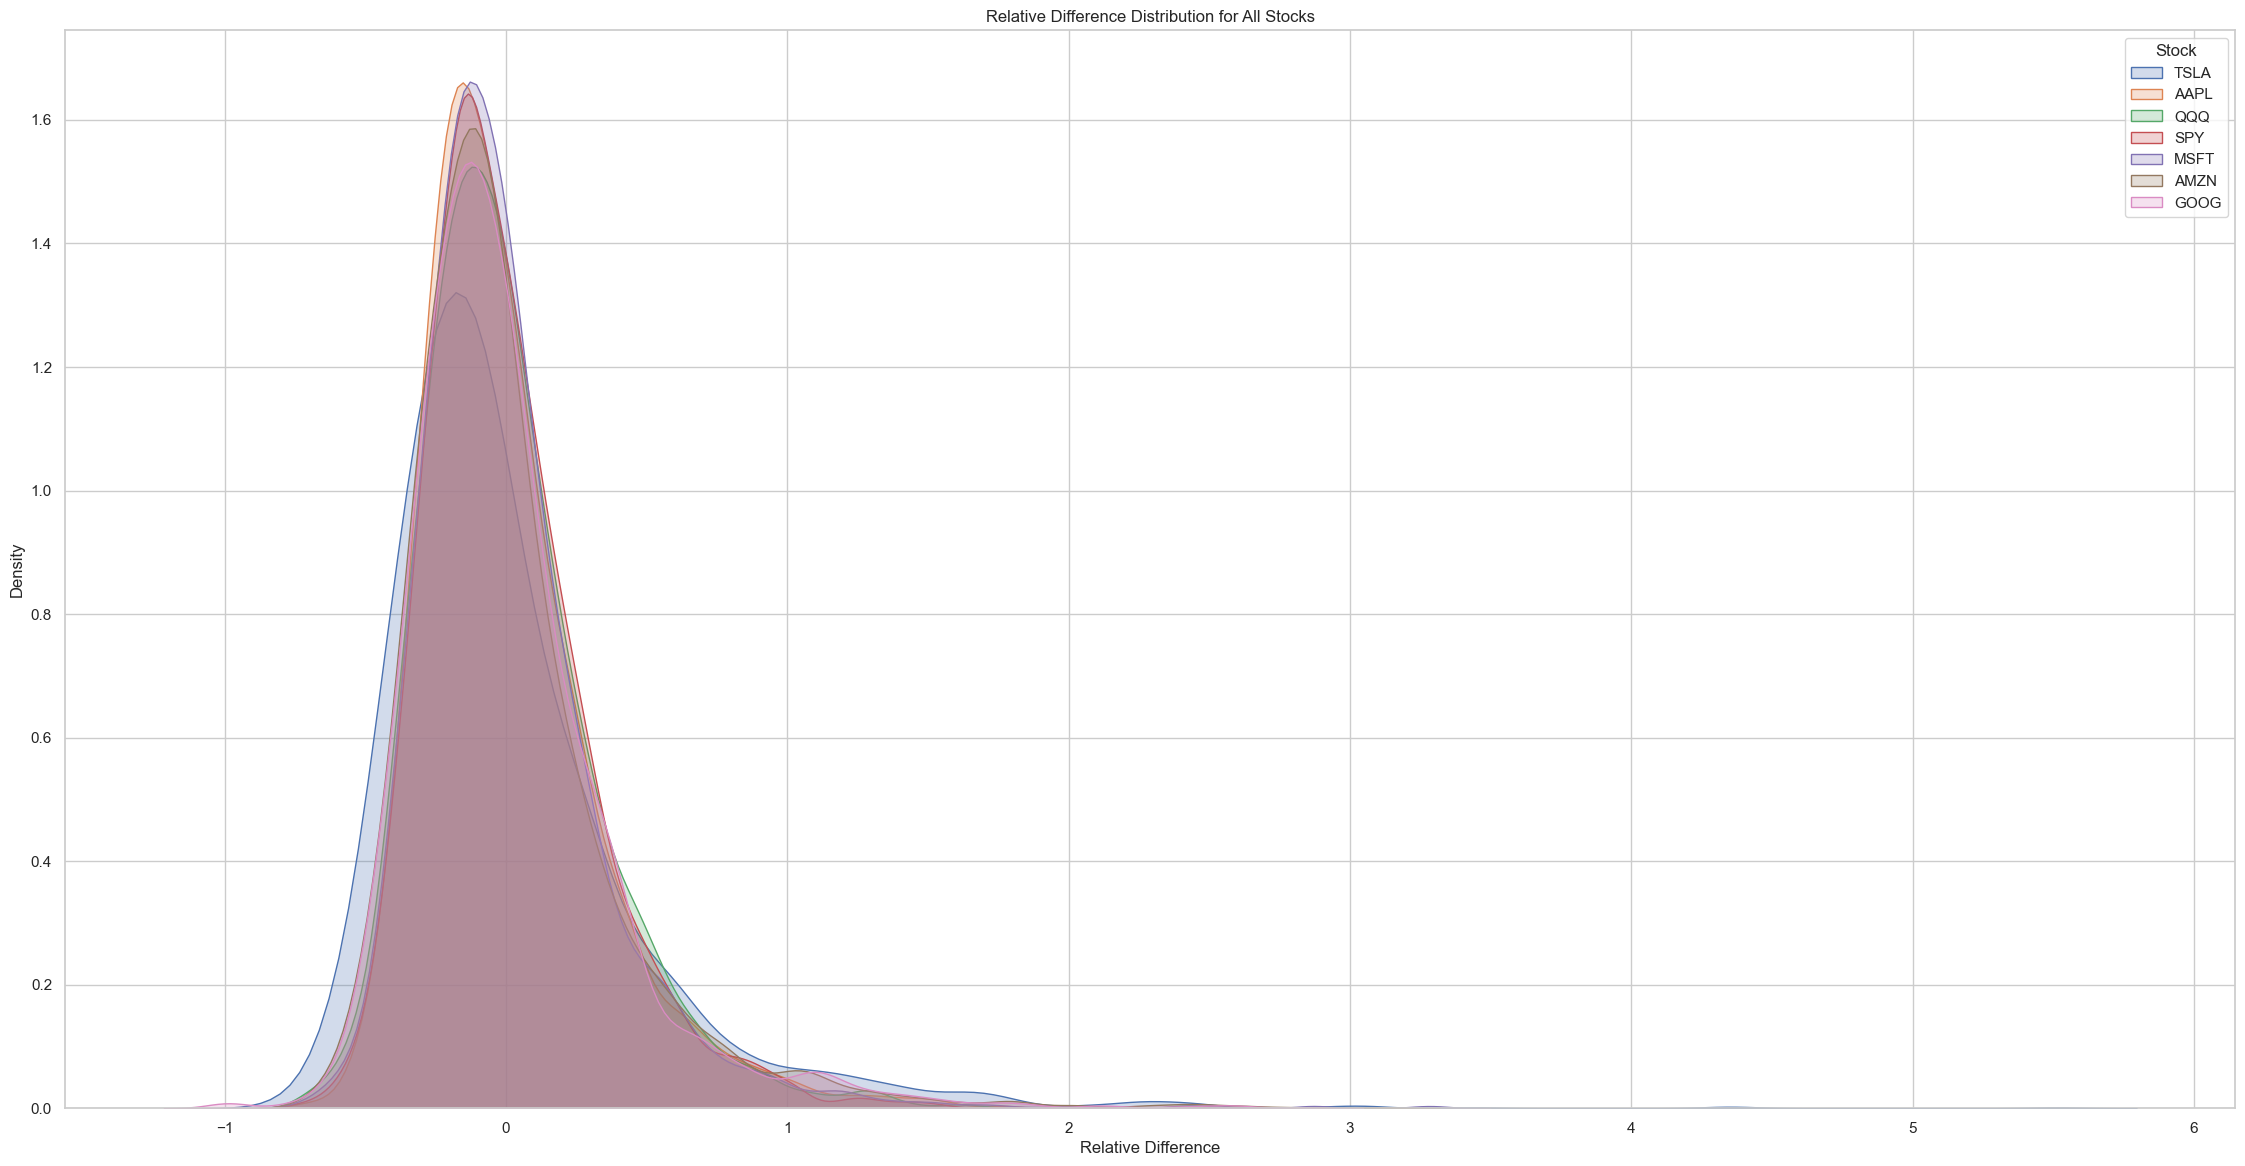

In [8]:
helper.plot_volume_distribution(stock_data)

### MA

### RSI

https://www.kaggle.com/code/riteshsinha/useful-features-in-predicting-stock-prices

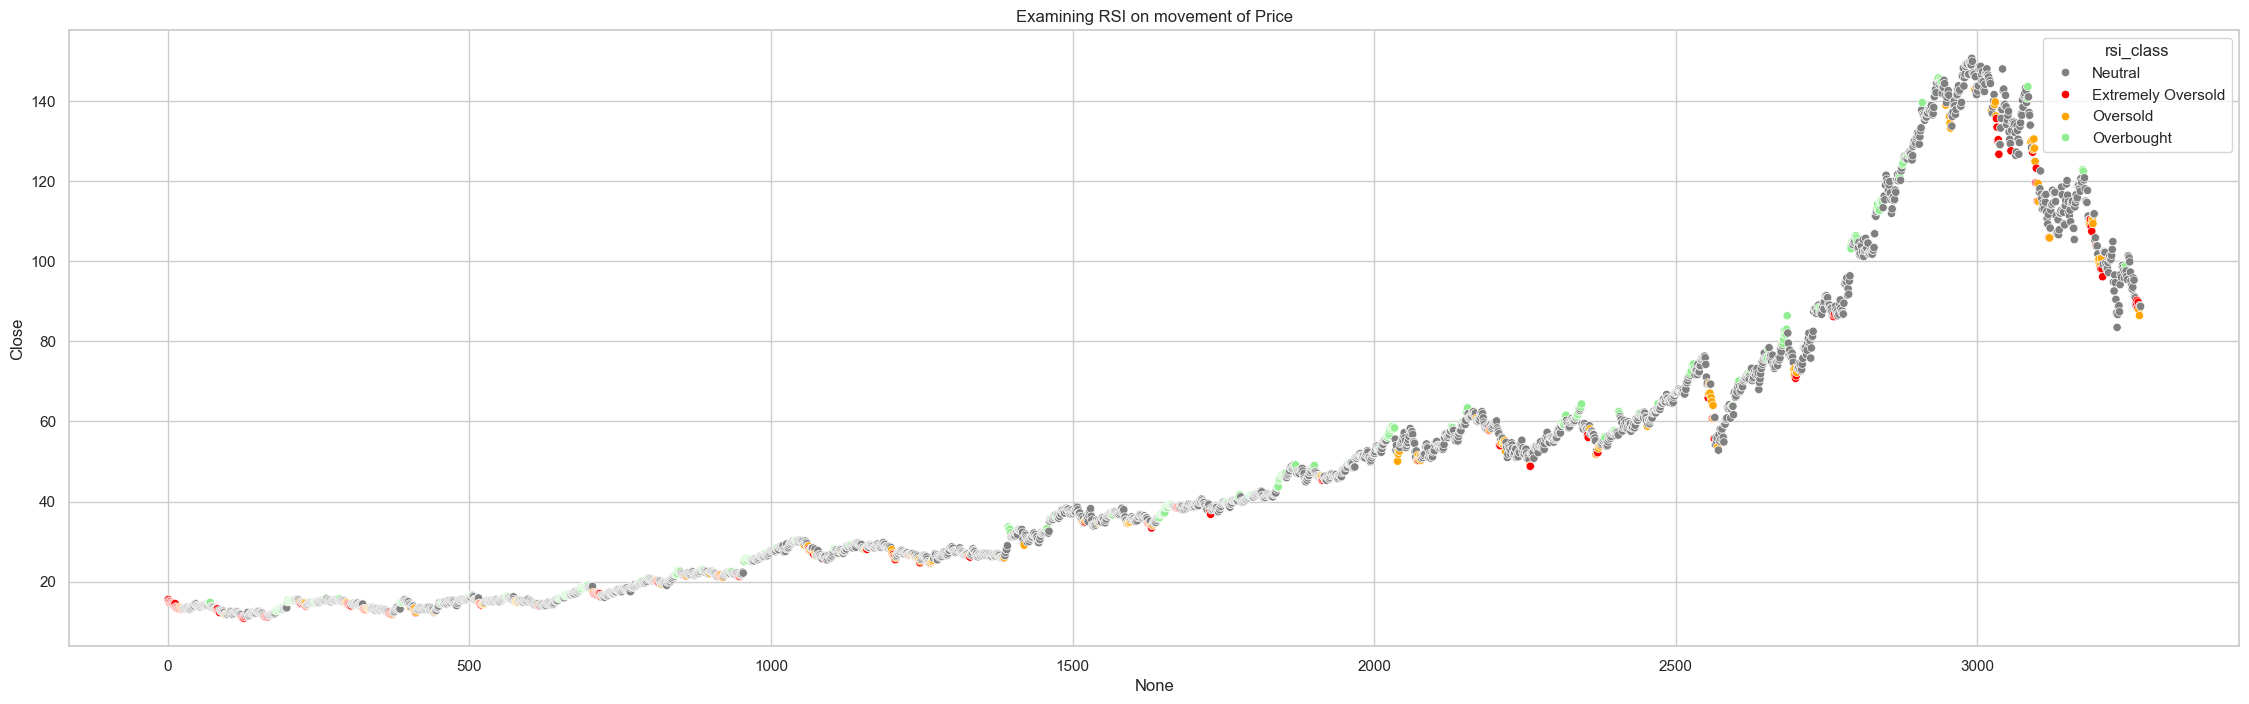

In [9]:
helper.plot_rsi_category(data)

In [10]:
y=data["Close"]

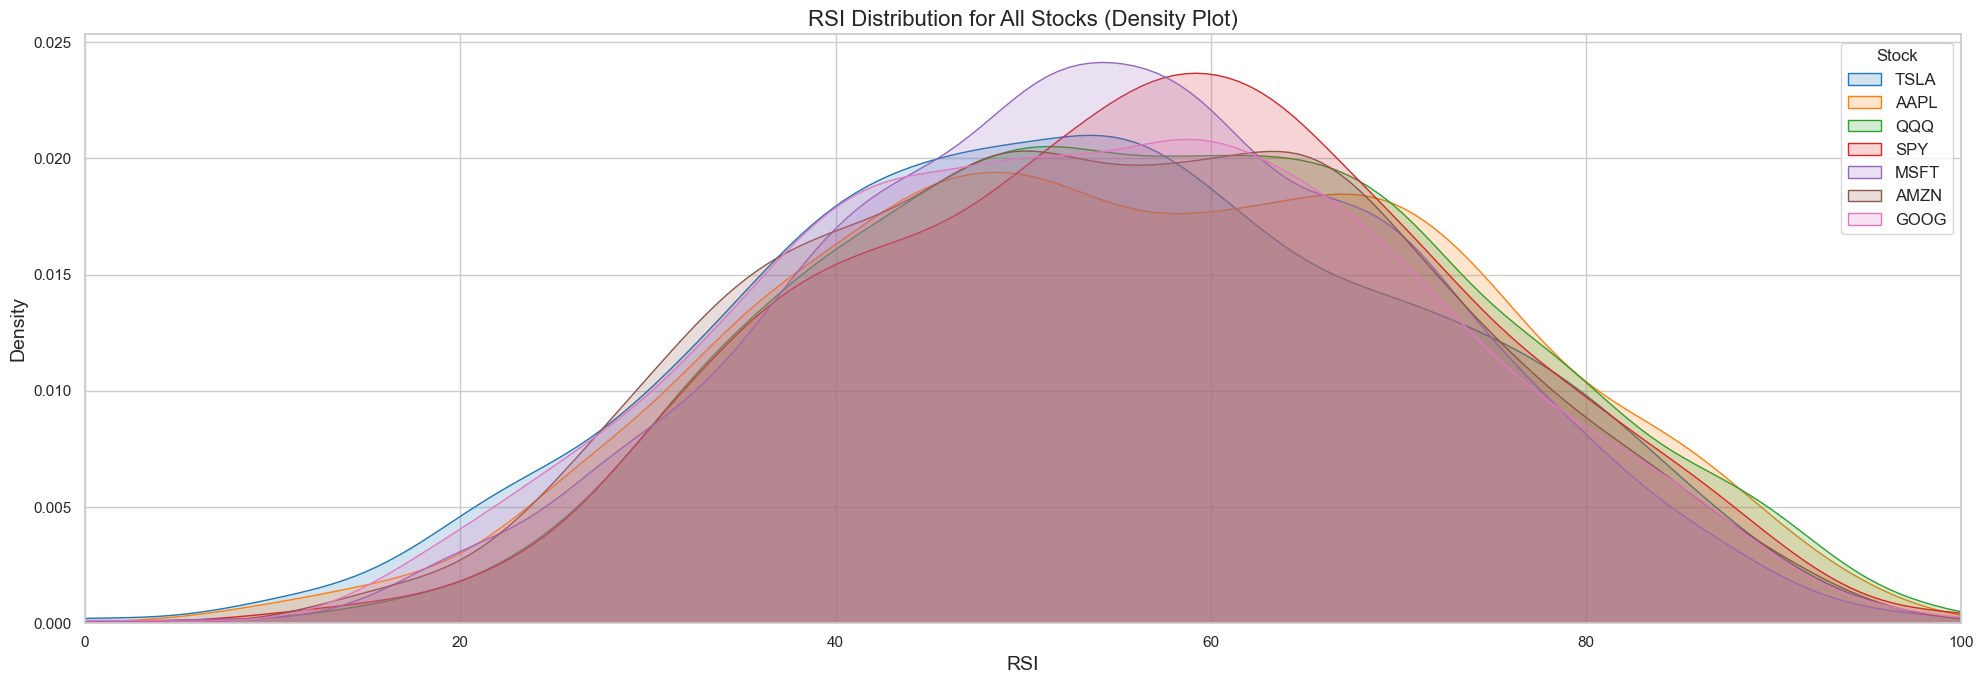

d:\Cornell\course\CS6386\Analyzing-the-Correlation-Between-Retail-Traders--Sentiments-and-Equity-Market-Movements\Stock_Analysis_Prediction\Stock\helper.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Stock", y="RSI", data=rsi_data_long, palette="tab10", boxprops=dict(alpha=.7), width=0.6)


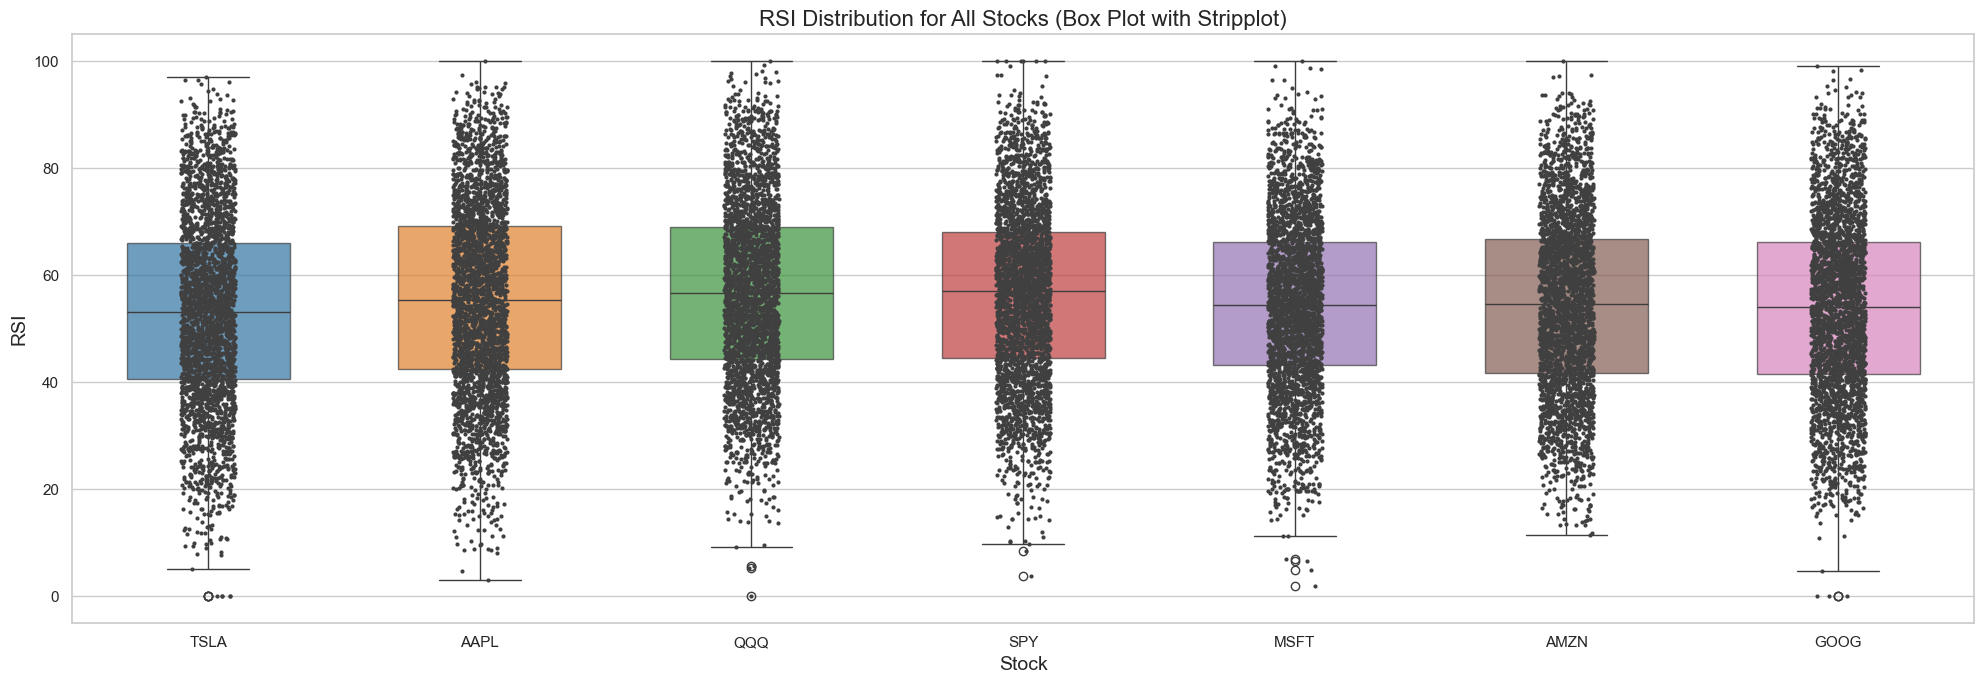

In [11]:
helper.plot_rsi_distribution(stock_data)

## XGBoost

### get the daily return

In [12]:
for stock in stock_data.keys():
    stock_data[stock]["return"] = stock_data[stock]['Close'].pct_change().fillna(0)
    stock_data[stock]['movement_category'] = stock_data[stock]['return'].apply(helper.categorize_movement)

In [13]:
apple_df = stock_data["AAPL"].copy()
apple_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,rsi_extremely_oversold_threshold,rsi_oversold_threshold,...,rsi_class,MA_Volume,Relative_Difference,volume_dip,minor_dip,minor_spike,volume_spike,volume_class,return,movement_category
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487535,493729600,NaN,26.74375,32.419832,...,Neutral,NaN,NaN,-0.314063,-0.17976,0.089288,0.395448,Neutral,0.000000,Stable
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498750,601904800,100.000000,26.74375,32.419832,...,Overbought,NaN,NaN,-0.314063,-0.17976,0.089288,0.395448,Neutral,0.001729,Stable
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395379,552160000,9.788567,26.74375,32.419832,...,Extremely Oversold,NaN,NaN,-0.314063,-0.17976,0.089288,0.395448,Neutral,-0.015906,Moderate Downtrend
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383556,477131200,8.873044,26.74375,32.419832,...,Extremely Oversold,NaN,NaN,-0.314063,-0.17976,0.089288,0.395448,Neutral,-0.001849,Stable
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425996,447610800,31.777433,26.74375,32.419832,...,Oversold,NaN,NaN,-0.314063,-0.17976,0.089288,0.395448,Neutral,0.006648,Slight Uptrend


In [14]:
apple_df = apple_df[['Date', 'Close', 'movement_category']]
apple_df

,Date,Close,movement_category
0,2010-01-04,7.643214,Stable
1,2010-01-05,7.656429,Stable
2,2010-01-06,7.534643,Moderate Downtrend
3,2010-01-07,7.520714,Stable
4,2010-01-08,7.570714,Slight Uptrend
...,...,...,...
3267,2022-12-23,131.860001,Slight Downtrend
3268,2022-12-27,130.029999,Moderate Downtrend
3269,2022-12-28,126.040001,Strong Downtrend
3270,2022-12-29,129.610001,Strong Uptrend


In [17]:
%%time

with SuppressFutureWarnings():
    for i in range(1, 11):  # for 10 days lag
        apple_df[f'lag_{i}'] = apple_df['Close'].shift(i)

    apple_df = apple_df.dropna()
    X = apple_df.drop(['Date', 'Close', 'movement_category'], axis=1)
    y = apple_df['movement_category']

    # Fit the LabelEncoder on the entire y series
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    window_size = 1000
    predictions = []
    true_values = []

    for start in tqdm(range(0, len(apple_df) - window_size), desc="Processing"):
        end = start + window_size
        
        X_train, X_test = X.iloc[start:end], X.iloc[end:end+1]
        y_train_encoded, y_test_encoded = y_encoded[start:end], y_encoded[end:end+1]

        # Check if all classes are present in the training data
        unique_train_labels = np.unique(y_train_encoded)
        if len(unique_train_labels) != len(label_encoder.classes_):
            print(f"Skipping window starting at {start} due to missing classes.")
            continue

        model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), n_jobs=-1)
        model.fit(X_train, y_train_encoded)

        y_pred_encoded = model.predict(X_test)
        y_pred = label_encoder.inverse_transform(y_pred_encoded)
        y_test_original = label_encoder.inverse_transform(y_test_encoded)

        predictions.append(y_pred[0])
        true_values.append(y_test_original[0])

Processing: 100%|██████████| 2262/2262 [21:23<00:00,  1.76it/s]

CPU times: total: 2h 12min 23s
Wall time: 21min 23s


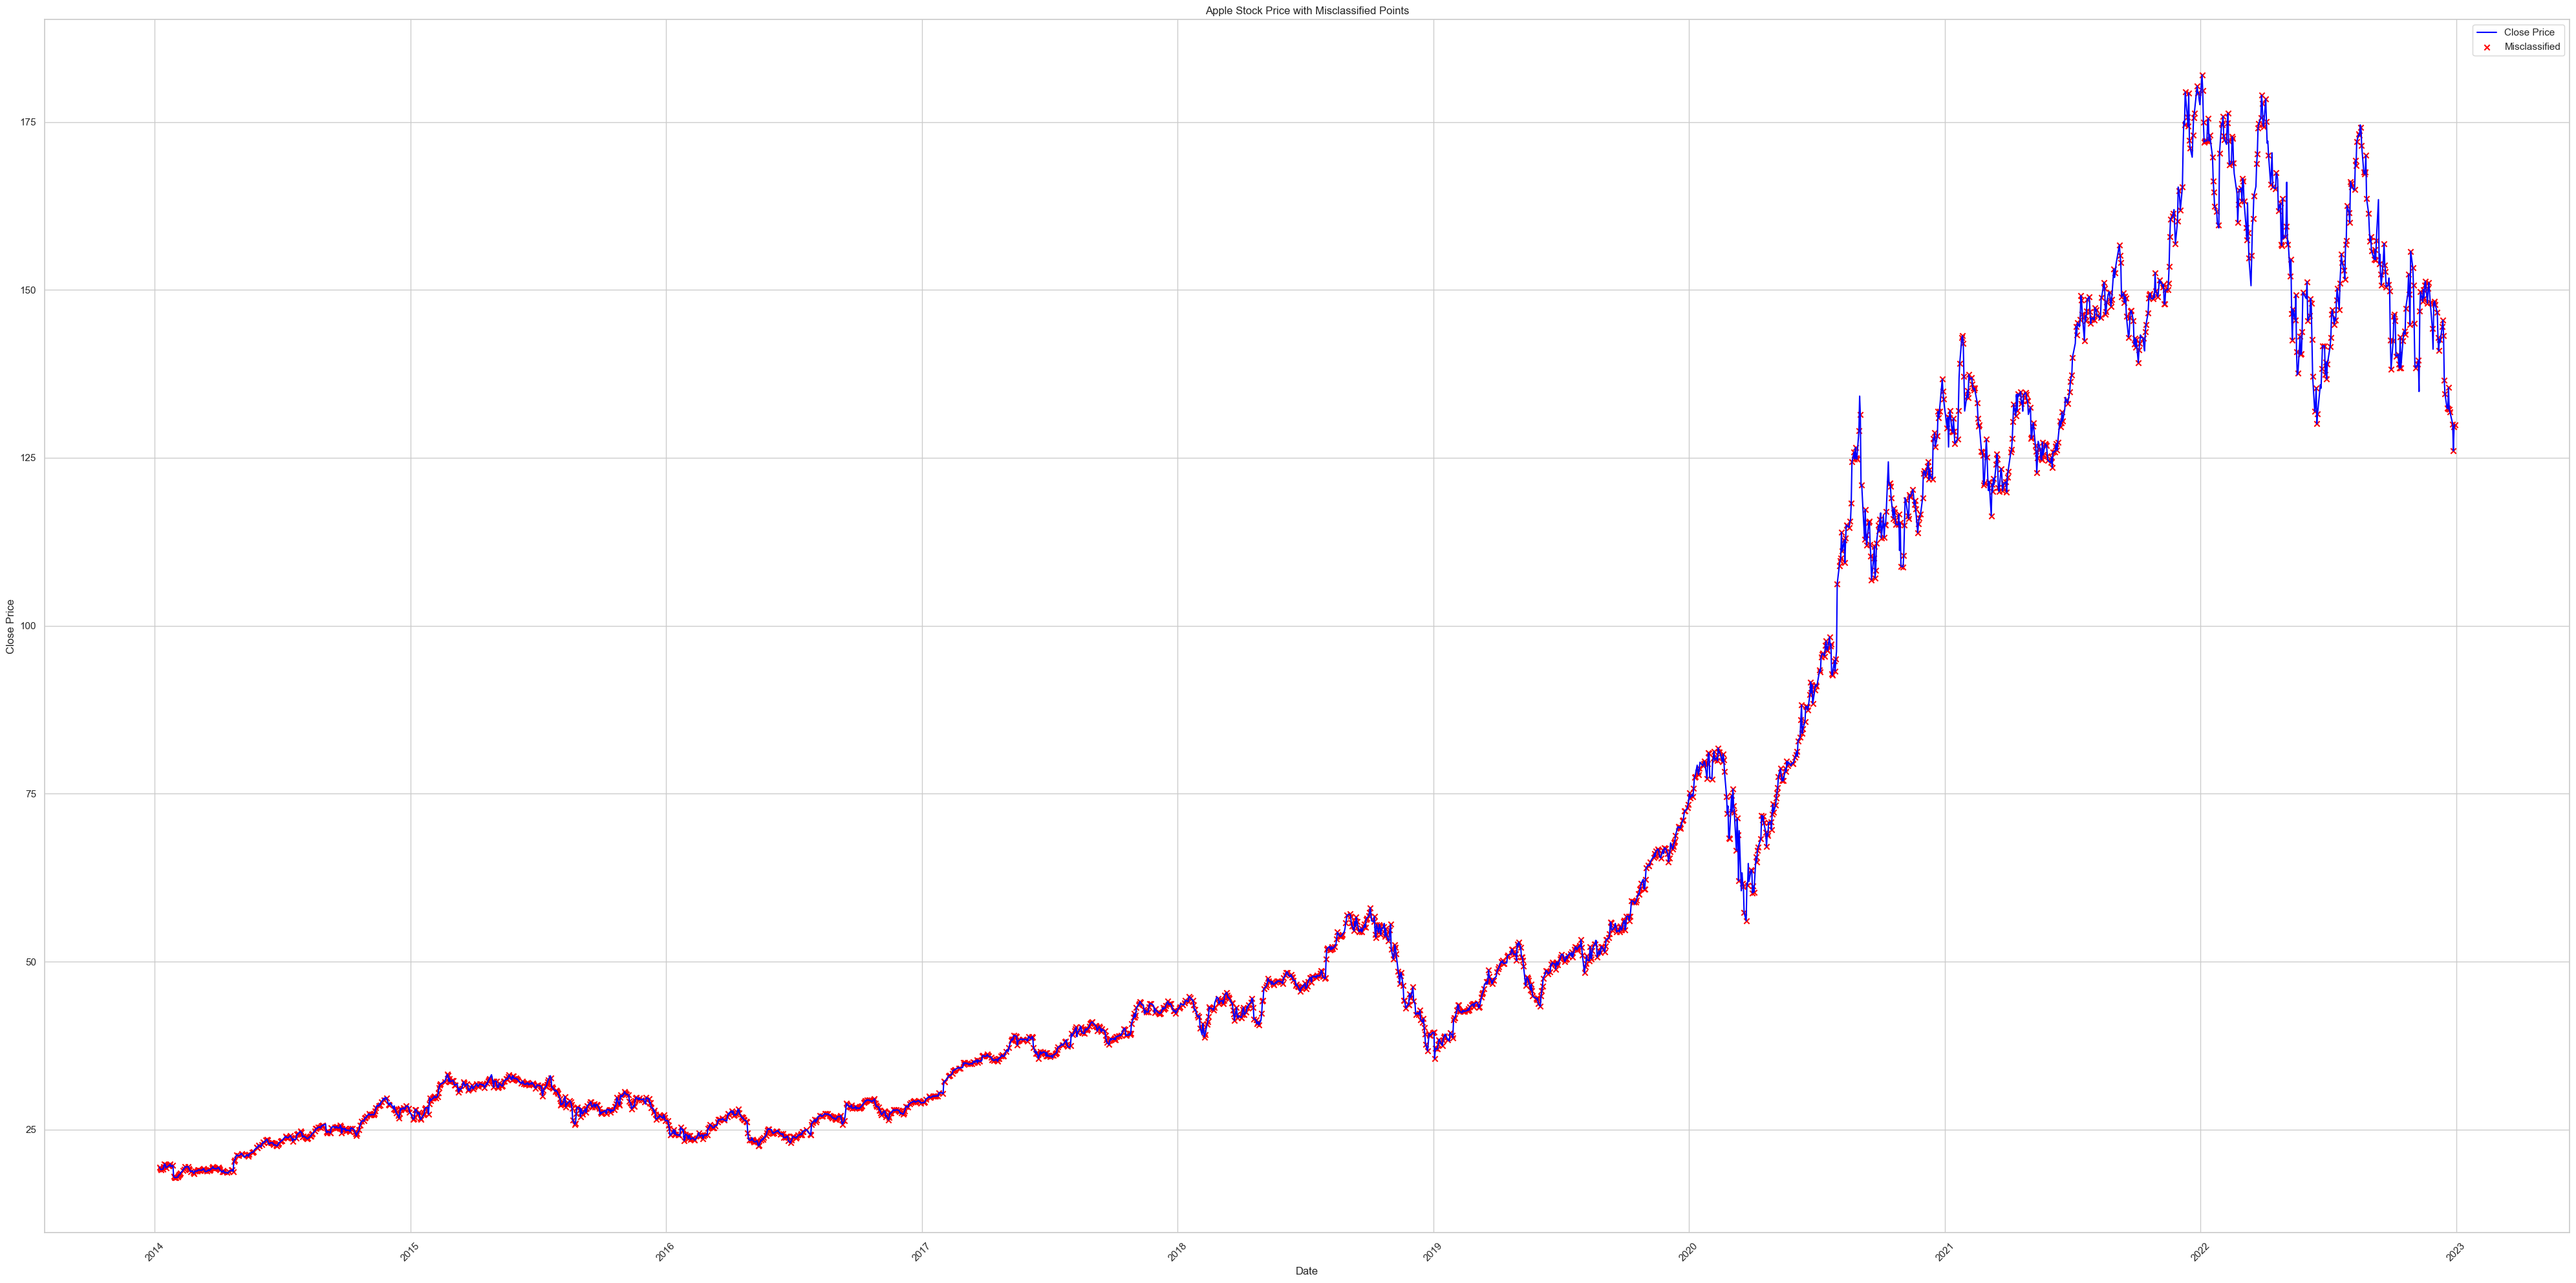

In [18]:
plt.figure(figsize=(40, 20))
plt.plot(apple_df['Date'][window_size:], apple_df['Close'][window_size:], label='Close Price', color='blue')

# Use markers for misclassified points
misclassified_dates = []
misclassified_prices = []
for pred, true, date, price in zip(predictions, true_values, apple_df['Date'][window_size:], apple_df['Close'][window_size:]):
    if pred != true:
        misclassified_dates.append(date)
        misclassified_prices.append(price)

plt.scatter(misclassified_dates, misclassified_prices, color='red', label='Misclassified', marker='x')

plt.title('Apple Stock Price with Misclassified Points')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45) 
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
label_encoder.classes_

array(['Moderate Downtrend', 'Moderate Uptrend', 'Slight Downtrend',
       'Slight Uptrend', 'Stable', 'Strong Downtrend', 'Strong Uptrend'],
      dtype=object)

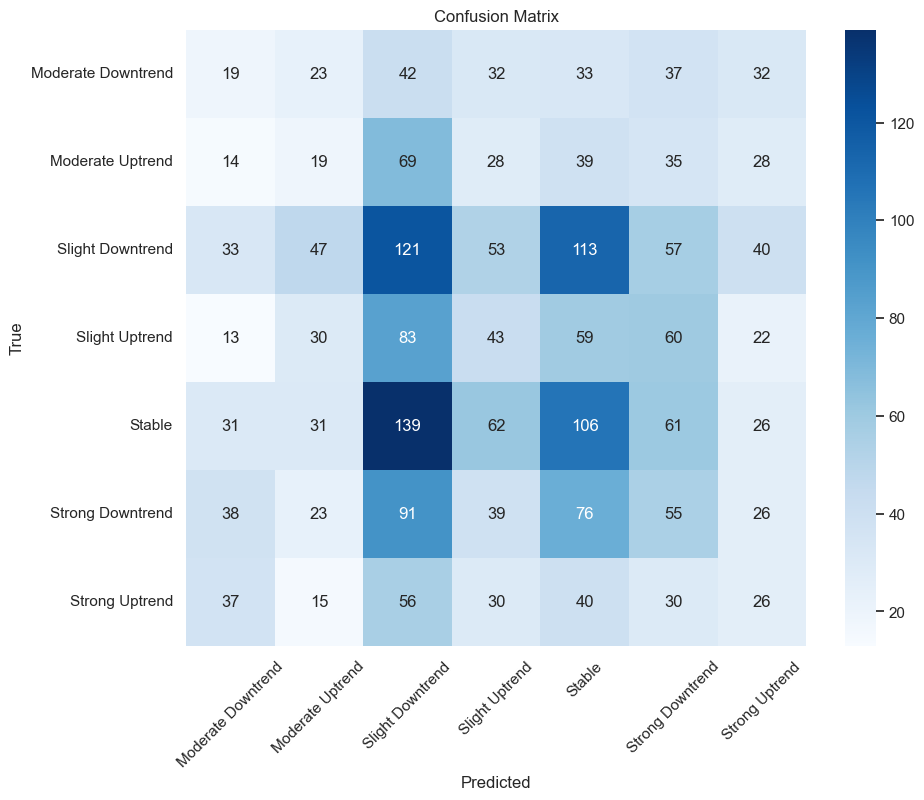

In [20]:
labels_order = ['Strong Downtrend', 'Moderate Downtrend', 'Slight Downtrend', 'Stable', 'Slight Uptrend', 'Moderate Uptrend', 'Strong Uptrend']
cm = confusion_matrix(true_values, predictions, labels=labels_order)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

In [21]:
accuracy = accuracy_score(true_values, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(true_values, predictions))

Accuracy: 17.20%
                    precision    recall  f1-score   support

Moderate Downtrend       0.10      0.08      0.09       232
  Moderate Uptrend       0.16      0.16      0.16       348
  Slight Downtrend       0.20      0.26      0.23       464
    Slight Uptrend       0.23      0.23      0.23       456
            Stable       0.15      0.14      0.14       310
  Strong Downtrend       0.10      0.09      0.09       218
    Strong Uptrend       0.13      0.11      0.12       234

          accuracy                           0.17      2262
         macro avg       0.15      0.15      0.15      2262
      weighted avg       0.17      0.17      0.17      2262



Feature Engineering:

Technical Indicators: Apart from lag features, consider using technical indicators like Moving Averages, Bollinger Bands, MACD, and others.
Sentiment Analysis: If you have access to news articles or financial reports, sentiment analysis can be a valuable feature.
Volume: Stock trading volume can be an indicator of momentum or upcoming price swings.
Calendar Features: Day of the week, month, quarter, and other time-based features can sometimes capture seasonal effects.
Model Evaluation:

Walk-forward Validation: This is a robust method for time series where you continually "walk" the training window forward in time.
Out-of-sample Testing: Always have a separate test set that the model hasn't seen during training or validation.
Model Complexity:

Ensemble Models: Models like Random Forest or Gradient Boosting Machines (like XGBoost) can capture non-linear relationships.
Deep Learning: LSTM, GRU, and Transformer-based models can be used for time series forecasting, but they require a lot of data and tuning.
Stationarity:

Time series data should ideally be stationary for many models to perform well. Consider techniques like differencing or using the ADF test to check for stationarity.
Regularization:

Overfitting can be a concern with time series data, especially with complex models. Regularization techniques can help.
External Factors:

Consider external events like economic indicators, geopolitical events, or company-specific news that might influence stock prices.
Model Interpretability:

Especially in finance, understanding why a model makes a particular prediction can be as important as the prediction itself. Tools like SHAP or LIME can help interpret complex models.
Risk Management:

Always be aware of the risks involved in stock trading. A model's prediction is just a tool and doesn't guarantee success.
Alternative Approaches:

Quantitative Strategies: Techniques like pairs trading, mean reversion, momentum strategies, etc.
Algorithmic Trading: If you're looking to automate the trading process based on the model's predictions.
Continuous Learning:

Financial markets evolve, and strategies can become obsolete. It's essential to continuously retrain and evaluate your models.
Lastly, always remember that the stock market is influenced by a myriad of factors, many of which are unpredictable. While models can provide insights and improve decision-making, they should be used judiciously and in conjunction with other tools and knowledge.

In [22]:
# window_sizes = [100, 200, 500, 1000]  # List of window sizes to test

# with SuppressFutureWarnings():
#     for i in range(1, 11):  # for 10 days lag
#         apple_df[f'lag_{i}'] = apple_df['Close'].shift(i)

#     apple_df = apple_df.dropna()
#     X = apple_df.drop(['Date', 'Close', 'movement_category'], axis=1)
#     y = apple_df['movement_category']

#     # Fit the LabelEncoder on the entire y series
#     label_encoder = LabelEncoder()
#     y_encoded = label_encoder.fit_transform(y)

#     for window_size in window_sizes:
#         print(f"Testing with window size: {window_size}")
#         predictions = []
#         true_values = []

#         for start in tqdm(range(0, len(apple_df) - window_size), desc="Processing"):
#             end = start + window_size

#             X_train, X_test = X.iloc[start:end], X.iloc[end:end+1]
#             y_train_encoded, y_test_encoded = y_encoded[start:end], y_encoded[end:end+1]

#             model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), n_jobs=-1)
#             model.fit(X_train, y_train_encoded)

#             y_pred_encoded = model.predict(X_test)
#             y_pred = label_encoder.inverse_transform(y_pred_encoded)
#             y_test_original = label_encoder.inverse_transform(y_test_encoded)

#             predictions.append(y_pred[0])
#             true_values.append(y_test_original[0])

#         # Error Analysis Plot
#         plt.figure(figsize=(20, 10))
#         plt.plot(apple_df['Date'][window_size:], apple_df['Close'][window_size:], label='Close Price', color='blue')
#         for i, (pred, true, date, price) in enumerate(zip(predictions, true_values, apple_df['Date'][window_size:], apple_df['Close'][window_size:])):
#             if pred != true:
#                 plt.annotate(f"Pred: {pred}\nTrue: {true}", (date, price), textcoords="offset points", xytext=(0,10), ha='center')
#         plt.title(f'Apple Stock Price with Predicted and True Movement Annotations (Window Size: {window_size})')
#         plt.xlabel('Date')
#         plt.ylabel('Close Price')
#         plt.legend()
#         plt.show()
